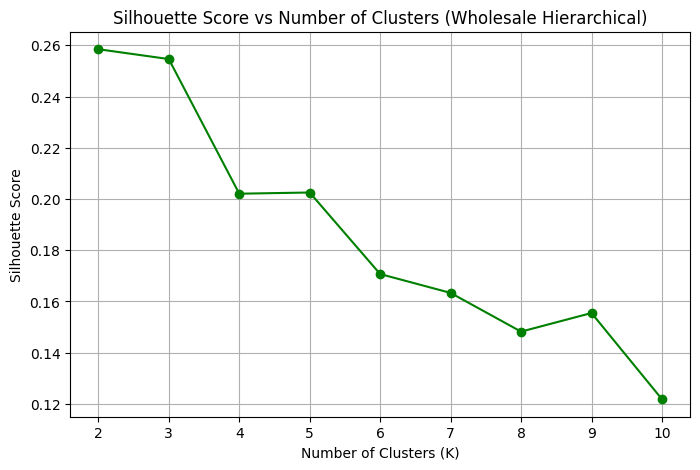

Best Number of Clusters based on Silhouette: 2
Best Silhouette Score: 0.2585


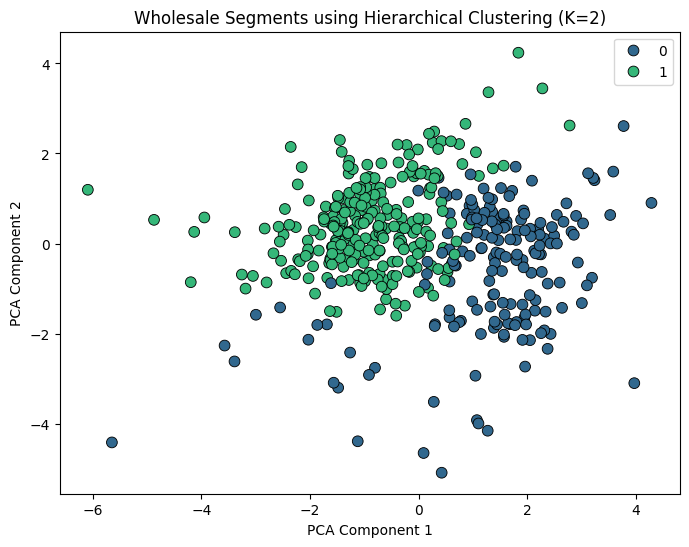

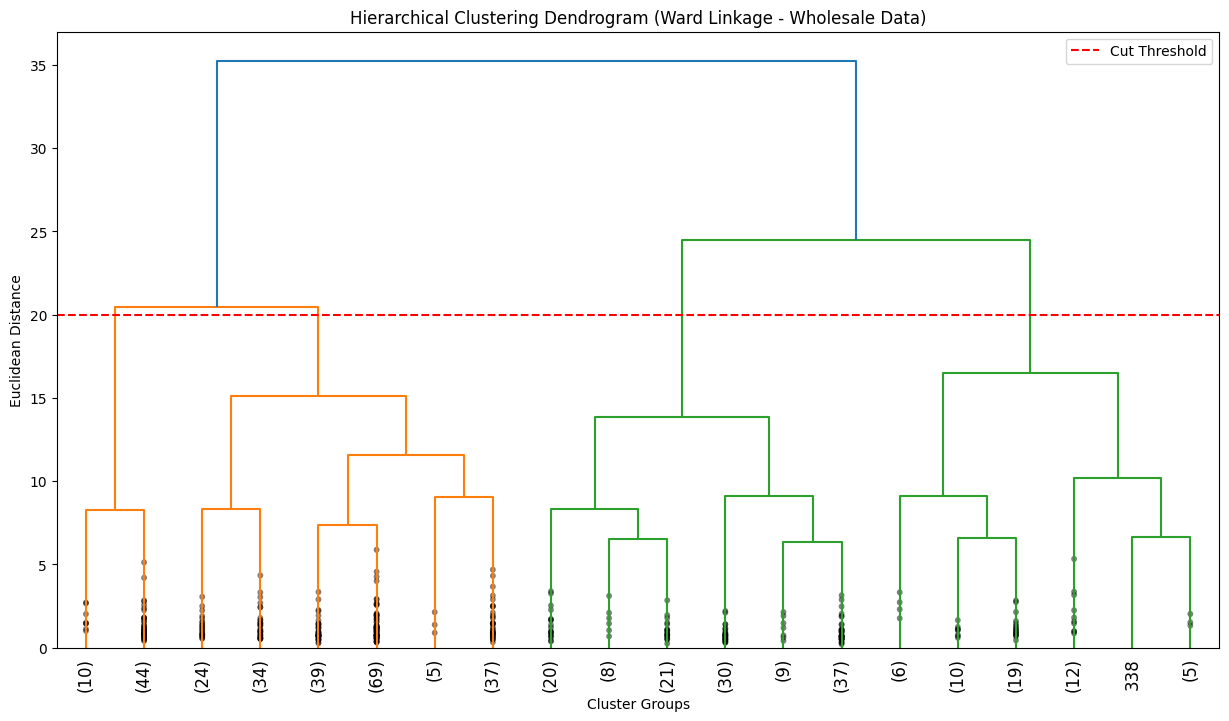

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. Load Dataset directly for Google Colab
# Using the Wholesale Customers dataset from UCI Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)

# 2. Preprocessing
# Drop categorical identifiers 'Channel' and 'Region' to focus on spending behavior
df_numeric = df.drop(columns=['Channel', 'Region'], errors='ignore')

# Handle skewness with Log Transformation - critical for Wholesale data
df_log = np.log1p(df_numeric)

# Handle potential missing values
df_log.fillna(df_log.mean(), inplace=True)

# Standardize the features for distance-based clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_log)

# 3. Finding Best K for Hierarchical Clustering
cluster_range = range(2, 11)
silhouette_scores = []

for k in cluster_range:
    # Applying Agglomerative Clustering with Ward Linkage [cite: 750, 819]
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X_scaled)
    # Measuring intra-cluster cohesion and inter-cluster separation [cite: 799, 816]
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot Silhouette vs K
plt.figure(figsize=(8,5))
plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters (Wholesale Hierarchical)")
plt.grid(True)
plt.show()

best_k = cluster_range[np.argmax(silhouette_scores)]
print(f"Best Number of Clusters based on Silhouette: {best_k}")
print(f"Best Silhouette Score: {round(max(silhouette_scores), 4)}")

# 4. Final Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
final_labels = hc.fit_predict(X_scaled)

# 5. PCA for 2D Visualization
# Reducing the 6 spending categories to 2 components for visual separation [cite: 804, 805]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=final_labels,
    palette='viridis',
    s=60,
    edgecolor='black',
    legend='full'
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Wholesale Segments using Hierarchical Clustering (K={best_k})")
plt.show()

# 6. Dendrogram (Full Dataset)
# Ward linkage minimizes within-cluster variance [cite: 819, 820]
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(15,8))
dendrogram(
    linked,
    truncate_mode='lastp', # Shows only the last p merged clusters [cite: 898]
    p=20,
    leaf_rotation=90,
    leaf_font_size=12,
    show_contracted=True
)
# A large vertical gap at the final merge indicates a natural partition [cite: 801, 827]
plt.axhline(y=20, color='red', linestyle='--', label='Cut Threshold')
plt.xlabel("Cluster Groups")
plt.ylabel("Euclidean Distance")
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage - Wholesale Data)")
plt.legend()
plt.show()